## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

In [3]:
from bs4 import BeautifulSoup

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

## Setup WebDriver

In [7]:
url = "https://www.google.com/flights/explore/#explore;f=LHR,LGW,STN,LTN,LCY,SEN,QQS;t=r-Australia-0x2b2bfd076787c5df%253A0x538267a1955b1352;li=3;lx=5;d=2018-05-31"
driver = webdriver.PhantomJS()
dcap = dict(DesiredCapabilities.PHANTOMJS)
dcap["phantomjs.page.settings.userAgent"] = ("Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36 OPR/49.0.2725.64") # This can be found by googeling what is my user agent
driver = webdriver.PhantomJS(desired_capabilities=dcap, service_args=["--ignore-ssl-errors=true"])
driver.implicitly_wait(20)
driver.get(url)

/home/treilly/Documents/projects/machine-learning-scratch/sklearn-air-fare/venv/lib64/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '
/home/treilly/Documents/projects/machine-learning-scratch/sklearn-air-fare/venv/lib64/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


In [8]:
driver.save_screenshot(r"screenshot.png")

True

## Create Soup

### Calculate the price per bar height 

In [9]:
s = BeautifulSoup(driver.page_source, "html5lib")

In [10]:
best_price_tags = s.find_all("div", "CTPFVNB-w-e")
best_prices = []
for tag in best_price_tags:
    best_prices.append(int(tag.text.replace("$", "").replace(",", "")))

In [11]:
best_prices

[832, 836, 839, 849, 910, 911]

In [12]:
best_height_tags = s.find_all("div", "CTPFVNB-w-f")
best_heights = []
for tag in best_height_tags:
    best_heights.append(float(tag.attrs["style"].split("height:")[1].replace("px;", "")))

In [13]:
best_heights

[50.41037606368378,
 46.697605295332856,
 55.60424174174174,
 50.89223630602083,
 49.4861713206889,
 45.71942572128251]

In [14]:
pph = np.array(best_prices[0])/np.array(best_heights[0])

In [15]:
pph

16.504538647934876

### Get Cities

In [16]:
cities = s.find_all("div", "CTPFVNB-v-m")

In [17]:
hlist = []
for bar in cities[0].find_all("div", "CTPFVNB-w-x"):
    hlist.append(float(bar.attrs["style"].split("height:")[1].replace("px;", ""))*pph)

In [18]:
fares = pd.DataFrame(hlist, columns=["price"])

In [19]:
fares

,price
0,849.808562
1,876.521405
2,917.100914
3,849.808562
4,849.808562
5,848.467917
6,848.467917
7,848.467917
8,875.190765
9,875.190765


## ML

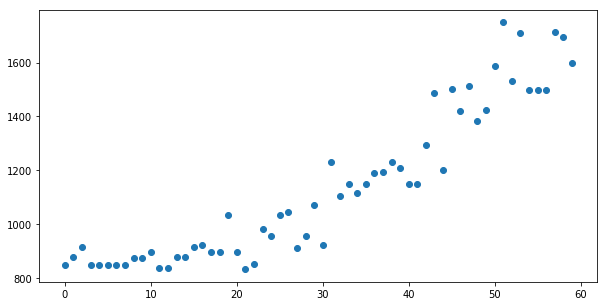

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))

plt.scatter(np.arange(fares["price"].size), fares["price"])

In [21]:
px = [x for x in fares.price]
ff = pd.DataFrame(px, columns=["fare"]).reset_index()

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [24]:
X = StandardScaler().fit_transform(ff)
db = DBSCAN(eps=0.5, min_samples=1).fit(X)

labels = db.labels_
unique_labes = set(labels)
clusters = len(unique_labes)
colors = plt.cm.Spectral(np.linspace(0, 1, clusters))


Text(0.5,1.01,'Total Clusters: 1')

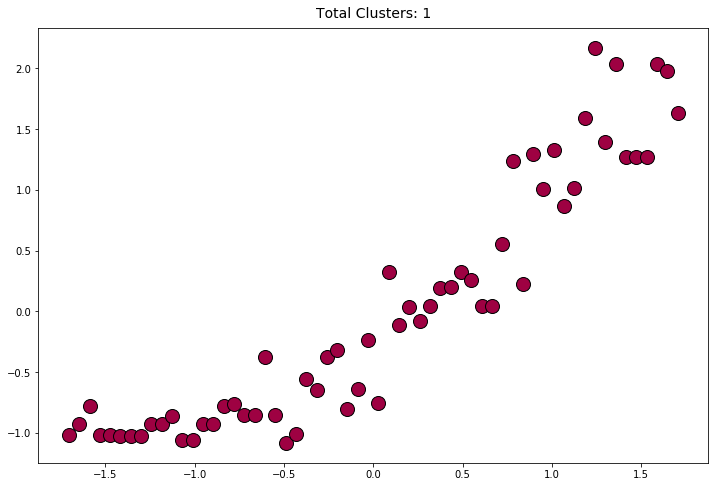

In [25]:
plt.subplots(figsize=(12,8))
for k,c in zip(unique_labes, colors):
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=c, markeredgecolor="k", markersize=14)
    
plt.title("Total Clusters: {}".format(clusters), fontsize=14, y=1.01)

In [26]:
pf = pd.concat([ff, pd.DataFrame(db.labels_, columns=["cluster"])], axis=1)
pf

,index,fare,cluster
0,0,849.808562,0
1,1,876.521405,0
2,2,917.100914,0
3,3,849.808562,0
4,4,849.808562,0
5,5,848.467917,0
6,6,848.467917,0
7,7,848.467917,0
8,8,875.190765,0
9,9,875.190765,0


In [27]:
rf = pf.groupby("cluster").fare.agg(["min", "count"])
rf

,min,count
cluster,,
0,832.0,60


In [28]:
rf.describe([.1,.25,.5,.75,.9])

,min,count
count,1.0,1.0
mean,832.0,60.0
std,NaN,NaN
min,832.0,60.0
10%,832.0,60.0
25%,832.0,60.0
50%,832.0,60.0
75%,832.0,60.0
90%,832.0,60.0
max,832.0,60.0
